<p style="background:#4c8527; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> European Football Database</b><br><br>
    - Exploratory Data Analysis -<br><br>
</p>

<p style="text-align: right;">Module 2: Data Analysis<br>
Sprint 4: Capstone Project<br>
Author : Renato Mariano</p>

<img src="campo_fut.jpg" width=400>

<h1 style="color:#4c8527">Introduction </h1>

This project will utilize a publicly available dataset from the popular platform Kaggle. The dataset in question is the European Soccer Database, which encompasses over 25,000 matches and more than 10,000 players from European professional soccer seasons between 2008 and 2016. The scraped data is available on https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european.


The objective of this notebook is to guide you through a complete process of analyzing the dataset and predicting the outcome of matches.

The following entity diagram shows the encompassed dataframes. For visualization purposes, the tables "Match", "Team_Attributes" and "Player_Attributes" only contain some of their features. They will be explored in more details during in the next sections of this notebook.

<img src="entity_diagram.png" width=850>

<h2 style="color:#4c8527">Objectives </h2>

The main goal of this project is to **create a model that predicts the number of goals and the winner of each match**.

<h2 style="color:#4c8527">Proposed Questions </h2>

The following questions are part of the project scope and will be answered during the analysis.

**Exploration**:
- Which leagues are in which countries?
- Which leagues score the most/fewest goals?
- Who are the top scorers in each team and league?
- Is there such a thing as home advantage?

**Model**:
- Can we predict how many goals each team will score in each match?
- Can we predict which team will win the match?

<h1 style="color:#4C8527">Library Imports and Notebook Setup</h1>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xmltodict

from statsmodels.stats.proportion import proportions_ztest

from suplement_functions import (select_all_columns, extract_goal_summary, clear_barplot, get_season)

In [2]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)       # control the amount of output digits

from IPython.core.display import HTML                             # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#4C8527">Exploratory Data Analysis</h1>

<h2 style="color:#4C8527">Available Dataframes</h2>

Let's start by connecting to the database and exploring its tables.

In [3]:
# Connect to the SQLite database
con = sqlite3.connect("data/soccer_data.sqlite")

# checking the database tables
table = pd.read_sql(select_all_columns("sqlite_master WHERE type='table'"), con)
table

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
sqlite_sequence = pd.read_sql(select_all_columns("sqlite_sequence"), con)
sqlite_sequence

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


The database is composed by 7 dataframes. Let's explore them, verify the consistency of the data and which data procedures are required.

All the dataframes will be stored in the dictionary (soccer_dict).

In [5]:
# Passes all the tables to a dictionary
soccer_dict = {}

for name in sqlite_sequence["name"]:
    soccer_dict[name] = pd.read_sql(select_all_columns(name), con)
soccer_dict.keys()

dict_keys(['Team', 'Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team_Attributes'])

Let's explore the dataset table-wise.

<h2 style="color:#4C8527">Team</h2>

The table "Team" contains information about the teams in the dataset.

In [6]:
soccer_dict['Team'].head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.000,KRC Genk,GEN
1,2,9993,675.000,Beerschot AC,BAC
2,3,10000,15005.000,SV Zulte-Waregem,ZUL
3,4,9994,2007.000,Sporting Lokeren,LOK
4,5,9984,1750.000,KSV Cercle Brugge,CEB


In [7]:
soccer_dict['Team'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [8]:
# Checking for duplicates on the team id
soccer_dict['Team'][soccer_dict['Team']['team_api_id'].duplicated()].shape

(0, 5)

In [9]:
# Checking for duplicates on the team long name
soccer_dict['Team'][soccer_dict['Team']['team_long_name'].duplicated(keep=False)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
15,16,9996,111560.000,Royal Excel Mouscron,MOU
24,2510,274581,111560.000,Royal Excel Mouscron,MOP
182,31444,8031,111429.000,Polonia Bytom,POB
183,31445,8020,111429.000,Polonia Bytom,GOR
189,31451,8244,301.000,Widzew Łódź,LOD
199,32409,8024,301.000,Widzew Łódź,WID


Most of the data is present, exception to some small percentage of fifa_ids.

No duplicated teams on the dataset, based on the team_api_id. 

Based on the long name of the teams we found 3 duplicated occurences, since their reference (team_api_id) might be used in further stages of the project, these values will no be dropped.

<h2 style="color:#4C8527">Country and League</h2>

These are 2 small dataframes representing the 11 countries that are encompassed in this dataset and the name of their respective soccer leagues.

In [10]:
soccer_dict['Country']

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [11]:
soccer_dict['League']

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


<h2 style="color:#4C8527">Player</h2>

Player is a datatable containing specific personal information about each player. This table does not contain null-values

In [12]:
soccer_dict['Player'].head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.880,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.180,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.180,163


In [13]:
soccer_dict['Player'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


In [14]:
# Checking for duplicates on the match id
print(f"Shape of duplicates by id: {soccer_dict['Player'][soccer_dict['Player']['player_api_id'].duplicated()].shape}")
print(f"Shape of duplicates by name: {soccer_dict['Player'][soccer_dict['Player']['player_name'].duplicated()].shape}")

Shape of duplicates by id: (0, 7)
Shape of duplicates by name: (212, 7)


Some duplicates were found for by players' names. Let's explore it further.

In [15]:
duplicated_player_names =  soccer_dict['Player']['player_name'].loc[soccer_dict['Player']['player_name'].duplicated()].values

soccer_dict['Player'][soccer_dict['Player']['player_name'].isin(duplicated_player_names)].tail(10)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
10738,10754,109616,Wellington,176962,1985-08-17 00:00:00,175.260,157
10739,10755,121957,Wellington,184845,1988-02-11 00:00:00,187.960,198
10755,10771,114364,Wesley,186600,1987-06-24 00:00:00,177.800,148
10756,10772,25617,Wesley,163092,1980-11-10 00:00:00,180.340,159
11017,11033,128047,Ze Eduardo,188001,1991-08-16 00:00:00,185.420,194
11018,11034,185867,Ze Eduardo,181132,1987-10-29 00:00:00,177.800,185
11020,11036,25906,Ze Manuel,139083,1975-02-22 00:00:00,167.640,143
11021,11037,570159,Ze Manuel,223339,1990-10-23 00:00:00,177.800,157
11029,11045,175259,Zezinho,190228,1992-03-14 00:00:00,175.260,139
11030,11046,244155,Zezinho,212639,1992-09-23 00:00:00,175.260,161


As we see, **many players have the same name, but different characteristics** (i.e. height, date of birth). Hence, they are not the same person. This happens specially amongst the Brazilian players who are normally called by their first name(s).

**No further treatment is needed** in this dataframe.

Out of curiosity let's see the distribution of birth year, height and weight of the players.

In [16]:
# Finding birth_years and weight in kg from pound
soccer_dict['Player']["birth_year"] = pd.DatetimeIndex(soccer_dict['Player']["birthday"]).year
soccer_dict['Player']['weight_kg'] = soccer_dict['Player']['weight'] / 2.205

# Description of numerical data
soccer_dict['Player'][["birth_year", 'weight_kg', 'height']].describe()

,birth_year,weight_kg,height
count,11060.000,11060.000,11060.000
mean,1986.643,76.363,181.867
std,5.481,6.798,6.369
min,1967.000,53.061,157.480
25%,1983.000,72.109,177.800
50%,1987.000,76.190,182.880
75%,1991.000,81.179,185.420
max,1999.000,110.204,208.280


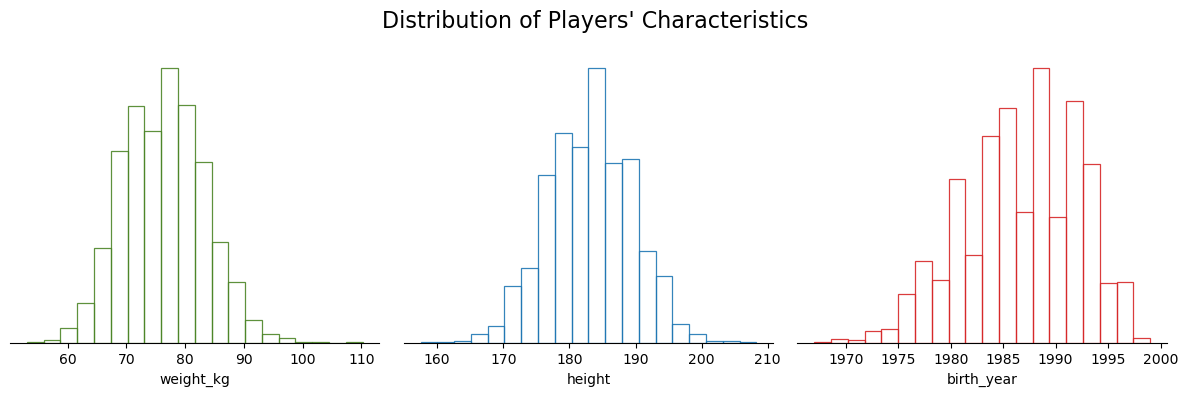

In [17]:
cols = ["weight_kg", "height", "birth_year"]
colors = ["#4C8527", "tab:blue", "tab:red"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(
        x=soccer_dict["Player"][col],
        bins=20,
        color=colors[i],
        alpha=0.9,
        fill=False,
        #stat = 'density',
        ax=ax,
    )
    
    sns.despine(left=True)
    ax.set(ylabel="")
    ax.set_yticklabels([])
    ax.tick_params(axis="y", which="both", length=0)

plt.suptitle("Distribution of Players' Characteristics", fontsize=16)
plt.tight_layout()

According to the data, the **median birth year** for players in the european soccer was **1987**. Their median **weight is 76 kg and height 182 cm**. Some players have heights of 157 cm and 208 cm (not commonly expected values). 

Furthermore, we can spot the **correlation betwen height and weight**, but this will not be further shown (outside of project scope).

<h2 style="color:#4C8527">Player Attributes</h2>

This dataframe contains technical information about each player. It is linked to the players' dataframe through their ids.

In general, an attribute is a skill that a player possesses, and its value ranges from 0 to 99. The average rating of these attributes is reflected in the 'overall_rating' field. The higher the value of these attributes, the better the player's skill.

The following quality labels can be assigned to an attribute:
- Excellent: 90 - 99
- Very Good: 80 - 89
- Good: 70 - 79
- Reasonable: 50 - 69
- Poor: 40 - 49
- Very Poor: 0 - 39

In [18]:
soccer_dict['Player_Attributes'].shape

(183978, 42)

In [19]:
soccer_dict['Player_Attributes'].head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.000,71.000,right,medium,medium,49.000,...,54.000,48.000,65.000,69.000,69.000,6.000,11.000,10.000,8.000,8.000
1,2,218353,505942,2015-11-19 00:00:00,67.000,71.000,right,medium,medium,49.000,...,54.000,48.000,65.000,69.000,69.000,6.000,11.000,10.000,8.000,8.000
2,3,218353,505942,2015-09-21 00:00:00,62.000,66.000,right,medium,medium,49.000,...,54.000,48.000,65.000,66.000,69.000,6.000,11.000,10.000,8.000,8.000


We can group the information in the dataframe into:

**Basic Player Information:** containing ids, date of attribute data, overall rating.

**Player Potential:** It represents the expected future performance improvement of the player.

**Player Preferred Foot:**

**Player Work Rate:** indicates how actively the player participates in the attack/deffence.


**Player Technical Attributes:** like crossing, finishing, heading_accuracy, penalties and so on.

**Player Physical Attributes:** like acceleration, strength, positioning, balance, etc.

**Goalkeeper Attributes:** gk_diving, gk_handling, gk_kicking, etc.

In [20]:
# Null values
soccer_dict['Player_Attributes'].isna().sum()*100/soccer_dict['Player_Attributes'].shape[0]

id                    0.000
player_fifa_api_id    0.000
player_api_id         0.000
date                  0.000
overall_rating        0.454
potential             0.454
preferred_foot        0.454
attacking_work_rate   1.756
defensive_work_rate   0.454
crossing              0.454
finishing             0.454
heading_accuracy      0.454
short_passing         0.454
volleys               1.475
dribbling             0.454
curve                 1.475
free_kick_accuracy    0.454
long_passing          0.454
ball_control          0.454
acceleration          0.454
sprint_speed          0.454
agility               1.475
reactions             0.454
balance               1.475
shot_power            0.454
jumping               1.475
stamina               0.454
strength              0.454
long_shots            0.454
aggression            0.454
interceptions         0.454
positioning           0.454
vision                1.475
penalties             0.454
marking               0.454
standing_tackle     

The dataframe does not contain more that 2% of Null values in any column.

<h3 style="color:#4C8527">Duplicated Measurements</h3>

In [21]:
# Comparing size with players dataframe
print(f"The number of rows of the players df is {soccer_dict['Player'].shape[0]}\n")

print(f"The number of unique players in players attributes is {soccer_dict['Player_Attributes']['player_api_id'].unique().shape[0]}")

The number of rows of the players df is 11060

The number of unique players in players attributes is 11060


As observed, there is a much higher number of rows for the players attributes (16 times higher). These attributes were maybe measured every season of competition more than once, or a lot more seasons were measured.

The number of unique players is however very similar in both dataframes.

Let's check for duplicated players and verify if for the same season no duplicated players will be presented.

In [22]:
# Duplicated players by api_id
soccer_dict['Player_Attributes'][soccer_dict['Player_Attributes']['player_api_id'].duplicated()].shape

(172918, 42)

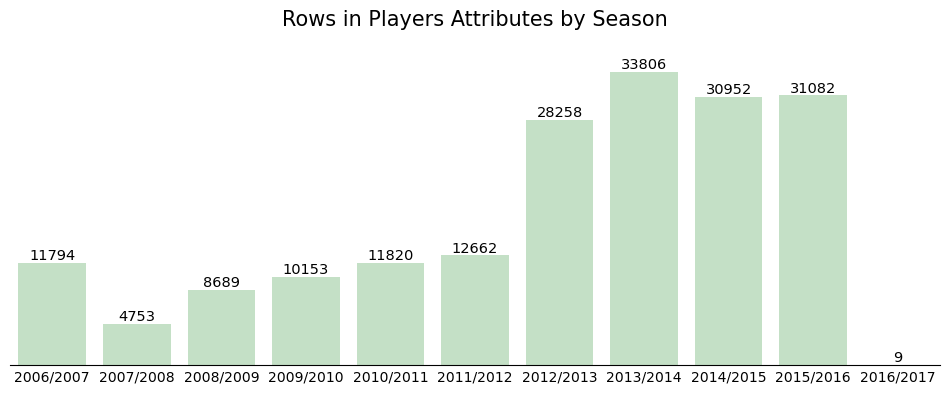

In [23]:
# Find the season for each player attribute
soccer_dict['Player_Attributes']['date'] = pd.to_datetime(soccer_dict['Player_Attributes']['date'])
soccer_dict['Player_Attributes']['Season'] = soccer_dict['Player_Attributes']['date'].apply(get_season)

player_attributes_season = soccer_dict["Player_Attributes"].groupby("Season").size().reset_index()
player_attributes_season.columns = ['Season', 'Count']
player_attributes_season

#Plot the data
fig, ax1 = plt.subplots(figsize=(12, 4))
sns.barplot(data=player_attributes_season, y='Count', x='Season', color="#a6d9aa", alpha=0.7, ax=ax1);
clear_barplot(ax1, plot_title="Rows in Players Attributes by Season\n", pad_top=0)

We see an increment of more than 2x from 2011-12 to 2012-13, indicating that maybe from this season on, players measurements were taken more frequently. 

This probably also highlights increases in investments in the European Futbool.

In [24]:
# Let's check for duplicates in each season
for s in player_attributes_season['Season']:
    player_attributes_season_messy = soccer_dict["Player_Attributes"][soccer_dict["Player_Attributes"]["Season"] == s]
    print(s, "  ", player_attributes_season_messy[player_attributes_season_messy['player_api_id'].duplicated()].shape[0])

2006/2007    735
2007/2008    258
2008/2009    2959
2009/2010    3918
2010/2011    5061
2011/2012    5709
2012/2013    21036
2013/2014    26374
2014/2015    23688
2015/2016    24025
2016/2017    0


For the same season there are still many duplicated players. Let's explore the data for the Brazilian player Neymar to get a sense of when these measurements were taken.

In [25]:
soccer_dict["Player"][soccer_dict["Player"]["player_name"] == "Neymar"]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,birth_year,weight_kg
7855,7867,19533,Neymar,190871,1992-02-05 00:00:00,175.260,150,1992,68.027


In [26]:
soccer_dict["Player_Attributes"][soccer_dict["Player_Attributes"]['player_api_id'] == 19533].groupby("Season").size()

Season
2006/2007    1
2009/2010    2
2010/2011    2
2011/2012    2
2012/2013    7
2013/2014    3
2014/2015    2
2015/2016    6
dtype: int64

The above count of the slice of the dataframe for the player Neymar highlights the increament in measures in the season 2012/2013. 
The lineplot bellow shows how the player's overall rating changed over time and within the same season.

The impact of these same season measurements in the model and the necessary further treatment of the data will be explained in the modelling section.

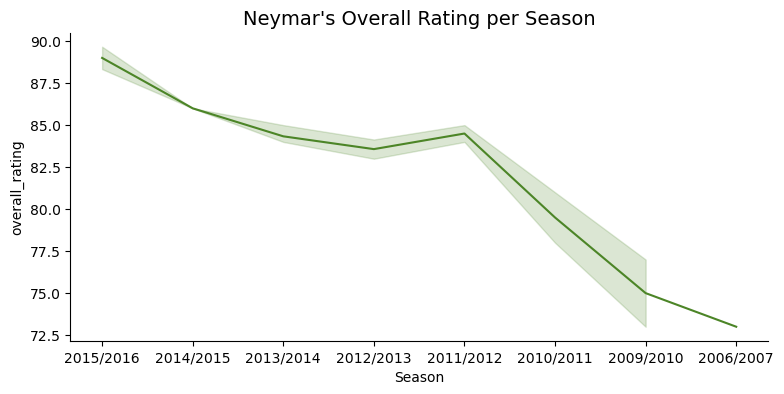

In [27]:
fig, ax1 = plt.subplots(figsize=(9, 4))
sns.lineplot(
    x="Season",
    y="overall_rating",
    data=soccer_dict["Player_Attributes"][soccer_dict["Player_Attributes"]['player_fifa_api_id'] == 190871],
    color="#4C8527",
    ax=ax1,
)
ax1.set_title("Neymar's Overall Rating per Season", color="black", fontsize=14)
sns.despine()

To handle the repeated measurements in one season, we will summarize the attributes by taking **the mode of each of them**. This way, we can condense the data and represent each player's attribute values based on the most frequent values per season.

**This procedure will only be carried out for the numerical features of the dataframe**. The categorical data ("preferred_foot", "attacking_work_rate", "defensive_work_rate", "date"), will not be further used in the modelling section.

In [28]:
# Condensed player's attributes dataframe
player_att_condensed = soccer_dict["Player_Attributes"].groupby(['player_api_id', 'Season']).agg("median").reset_index()
player_att_condensed.head(3)

,player_api_id,Season,id,player_fifa_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,2006/2007,139857.000,148544.000,63.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,11.000,67.000,9.000,10.000
1,2625,2007/2008,139856.000,148544.000,63.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,24.000,67.000,24.000,24.000
2,2625,2008/2009,139855.000,148544.000,60.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,24.000,67.000,24.000,24.000


In [29]:
print(
    f"The percentage of remaining rows is {player_att_condensed.shape[0]*100 / soccer_dict['Player_Attributes'].shape[0]:.1f}%"
)

The percentage of remaining rows is 38.2%


<h3 style="color:#4C8527">Overrall Rating vs Potential</h3>

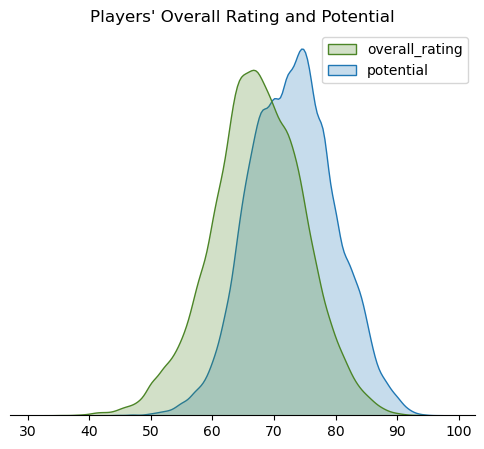

In [30]:
fig, ax1 = plt.subplots(figsize=(6, 5))

sns.kdeplot(
    data=player_att_condensed[["overall_rating", "potential"]],
    shade=True,
    legend=True,
    palette=["#4C8527", "tab:blue"],
)

sns.despine(left=True)
ax1.set(title="Players' Overall Rating and Potential", ylabel="")
ax1.set_yticklabels([])
ax1.tick_params(axis="y", which="both", length=0)

The overall rating of players is distributed normally with average around 65. The values for the potential of the players is higher with mode arround 75. 

<h3 style="color:#4C8527">Features Correlation</h3>

Although difficult to understand when so many features are involved, a correlation matrix can provide some insights on the relationship between features and for the development of our model.

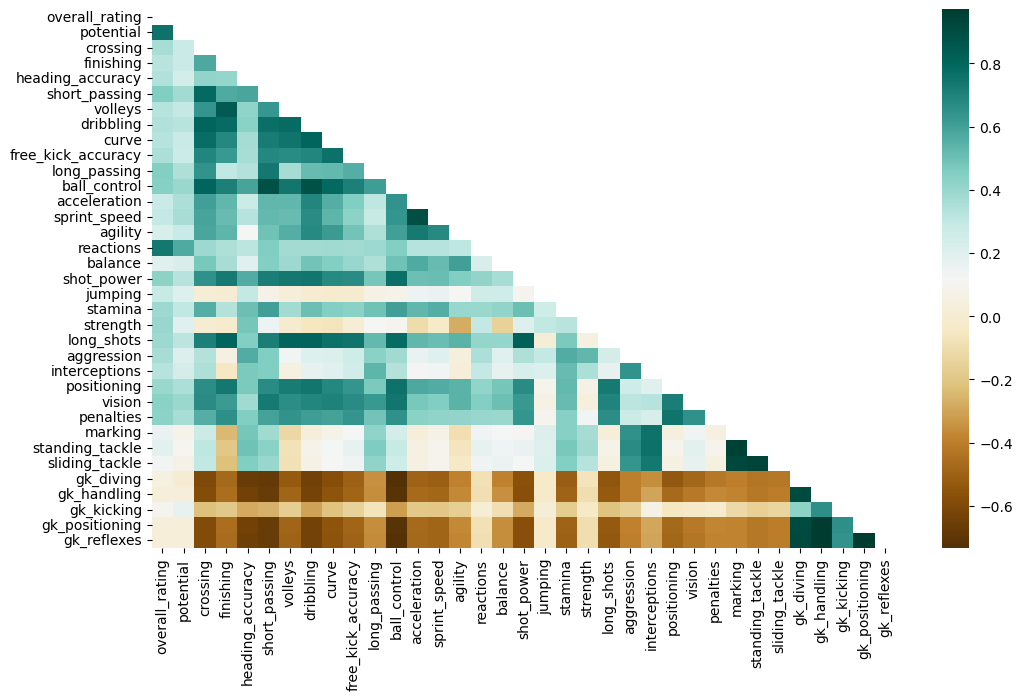

In [31]:
matrix = np.triu(player_att_condensed.iloc[:,4:40].corr()) # returns the Upper triangle of an array

plt.figure(figsize=(12, 7))
sns.heatmap(player_att_condensed.iloc[:,4:40].corr(), annot=False, cmap="BrBG", mask=matrix, fmt=".2f");

In general terms and as expected, the overall rating is well correlated to the features that compose it (until penalties). Reactions and Potential are very highly correlated to the overrall rating.

Furthermore, there is a tendency that players with good Goalkeeper characteristics do not develop well as a normal player (negative correlations).

<h2 style="color:#4C8527">Team Attributes</h2>

Technical information about each team is shown in this dataframe.

In [32]:
soccer_dict['Team_Attributes'].shape

(1458, 25)

In [33]:
soccer_dict['Team_Attributes'].head(3)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.000,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.000,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover


In [34]:
soccer_dict['Team_Attributes'].isna().sum()*100/soccer_dict['Team_Attributes'].shape[0]

id                                0.000
team_fifa_api_id                  0.000
team_api_id                       0.000
date                              0.000
buildUpPlaySpeed                  0.000
buildUpPlaySpeedClass             0.000
buildUpPlayDribbling             66.461
buildUpPlayDribblingClass         0.000
buildUpPlayPassing                0.000
buildUpPlayPassingClass           0.000
buildUpPlayPositioningClass       0.000
chanceCreationPassing             0.000
chanceCreationPassingClass        0.000
chanceCreationCrossing            0.000
chanceCreationCrossingClass       0.000
chanceCreationShooting            0.000
chanceCreationShootingClass       0.000
chanceCreationPositioningClass    0.000
defencePressure                   0.000
defencePressureClass              0.000
defenceAggression                 0.000
defenceAggressionClass            0.000
defenceTeamWidth                  0.000
defenceTeamWidthClass             0.000
defenceDefenderLineClass          0.000


As shown, this df only possesses null values for the feature 'buildUpPlayDribbling', 65%.

In [35]:
# Unique and Duplicated values
print("Unique Teams", soccer_dict['Team_Attributes']['team_api_id'].unique().shape[0])
print("Duplicated rows", soccer_dict['Team_Attributes'][soccer_dict['Team_Attributes']['team_api_id'].duplicated()].shape[0])

Unique Teams 288
Duplicated rows 1170


A total of **288 teams** are present in the dataset. Duplicated values are found in this datatable and they reflect measurements taken over the years for the same team. 

Let's evaluate if for the **same season repeated measurements** are also to be found.

In [36]:
# Find the season for each row
soccer_dict['Team_Attributes']['date'] = pd.to_datetime(soccer_dict['Team_Attributes']['date'])
soccer_dict['Team_Attributes']['Season'] = soccer_dict['Team_Attributes']['date'].apply(get_season)

# Find the duplicated teams by season
duplicated_teams = soccer_dict['Team_Attributes'].duplicated(subset=['team_api_id', 'Season'])
soccer_dict['Team_Attributes'][duplicated_teams]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,Season
860,861,111560,9996,2015-09-10,50,Balanced,50.000,Normal,50,Mixed,...,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,2015/2016


In [37]:
# Drop this single duplicated value.
soccer_dict['Team_Attributes'].drop_duplicates(subset=['team_api_id', 'Season'], inplace=True)
soccer_dict['Team_Attributes'].shape

(1457, 26)

<h3 style="color:#4C8527">Features Correlation</h3>

As in the map bellow, the teams' attributes seem to describe unrelated features, hence the lower correlation values. Exception for the defense features.

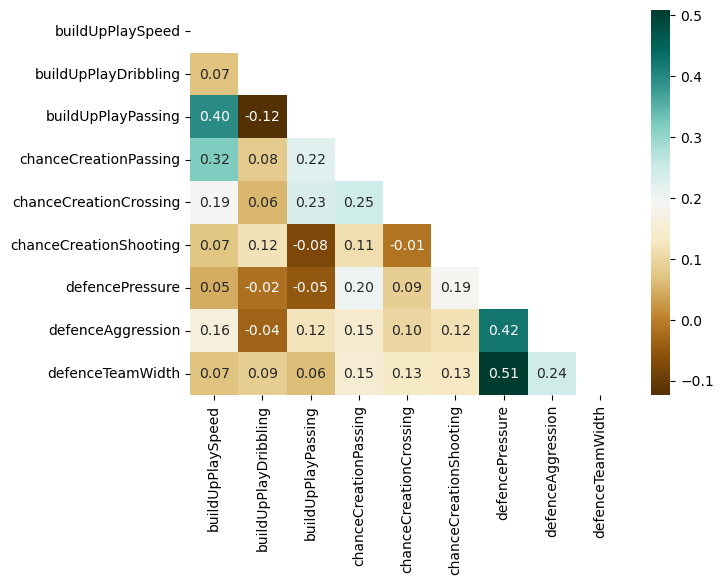

In [38]:
matrix = np.triu(soccer_dict['Team_Attributes'].iloc[:,3:].corr()) # returns the Upper triangle of an array

plt.figure(figsize=(7, 5))
sns.heatmap(soccer_dict['Team_Attributes'].iloc[:,3:].corr(), annot=True, cmap="BrBG", mask=matrix, fmt=".2f");

<h2 style="color:#4C8527">Match</h2>

Match is a very big dataframe containing information on all of the matches for the encompassed soccer leagues. 115 columns are contained in this dataframe, almost 26.000 matches.

This dataframe contains the following group of features

**Match Information**:
like ids for match, country, league. Season, Stage of match. Dates. Home and away teams and goals.

**Player Position Coordinates (home_player_X# and home_player_Y#; away_player_X# and away_player_Y#)**:
The X and Y coordinates represent the positions of players on the field. These columns provide information about the positions of players 1 to 11 for both home and away teams.

**Player Information (home_player_# and away_player_#)**:
The columns home_player_1 to home_player_11 contain information about the players in the home team.
The columns away_player_1 to away_player_11 contain information about the players in the away team.

**Match Events**:
Information about the goals, shots on and off target, fouls, cards, etc.

**Betting Odds**:
The last columns of the df consist of betting odds from different companies.

In [39]:
soccer_dict['Match'].shape

(25979, 115)

In [40]:
# Null values
pd.set_option("display.max_rows", None)

missing_data_Match = pd.concat(
    [
        soccer_dict["Match"].isna().sum() * 100 / soccer_dict["Match"].shape[0],
        soccer_dict["Match"].dtypes,
    ],
    axis=1,
)
missing_data_Match.columns = ["Missing Percentage", "Data Type"]
missing_data_Match

,Missing Percentage,Data Type
id,0.000,int64
country_id,0.000,int64
league_id,0.000,int64
season,0.000,object
stage,0.000,int64
date,0.000,object
match_api_id,0.000,int64
home_team_api_id,0.000,int64
away_team_api_id,0.000,int64
home_team_goal,0.000,int64


As exposed, for about 7% of the data the Home and Away Players are missing.

Some of the features, like 'goal', 'card', 'cross' and 'possession' is missing for about 45% of the matches.

Besides, between 13% to 57% of the last features of the dataframe (Betting odds) are missing.

In [41]:
# return the default rows presentation
pd.set_option('display.max_rows', 50) 

# Checking for duplicates on the match id
soccer_dict['Match'][soccer_dict['Match']['match_api_id'].duplicated()].shape

(0, 115)

No duplicated matches in this dataset.

<h3 style="color:#4C8527">Recorded Competition Seasons</h3>

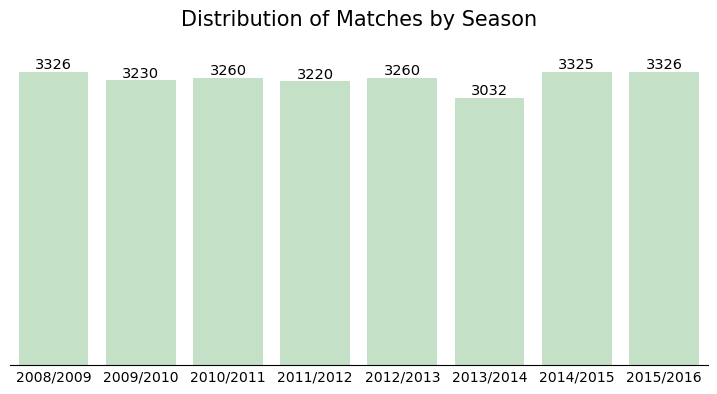

In [42]:
# Group the data by season
matches_by_season = soccer_dict['Match'].groupby('season').size().reset_index()
matches_by_season.columns = ['season', 'Count']

#Plot the data
fig, ax1 = plt.subplots(figsize=(9, 4))
sns.barplot(data=matches_by_season, y='Count', x='season', color="#a6d9aa", alpha=0.7, ax=ax1);
clear_barplot(ax1, plot_title="Distribution of Matches by Season\n", pad_top=0)

In [43]:
matches_by_season.dtypes

season    object
Count      int64
dtype: object

There is a small fluctuation in the number of matches throughout the seasons (expected).
Let's explore further to see if there is consistent data for the leagues.

<h3 style="color:#4C8527">Leagues by Seasons</h3>

In [44]:
soccer_dict["Match"]['season']

0        2008/2009
1        2008/2009
2        2008/2009
3        2008/2009
4        2008/2009
           ...    
25974    2015/2016
25975    2015/2016
25976    2015/2016
25977    2015/2016
25978    2015/2016
Name: season, Length: 25979, dtype: object

In [45]:
# Group the data by 'league_id' and season
matches_by_league_and_season = (
    soccer_dict["Match"]
    .groupby(["league_id", "season"])
    .size()
    .reset_index()
)

# Merge League's name
matches_by_league_and_season = pd.merge(
    matches_by_league_and_season,
    soccer_dict["League"],
    left_on="league_id",
    right_on="id",
    how="inner",
).drop(["id", "country_id"], axis=1)

matches_by_league_and_season.columns = ['league_id', 'Season', 'Count', 'League Name']
#matches_by_league_and_season['Season'] = matches_by_league_and_season['Season'].astype(str)

matches_by_league_and_season.head(3)

,league_id,Season,Count,League Name
0,1,2008/2009,306,Belgium Jupiler League
1,1,2009/2010,210,Belgium Jupiler League
2,1,2010/2011,240,Belgium Jupiler League


 Now we have our data with the count of matches for each season. Let's visualize it graphically.

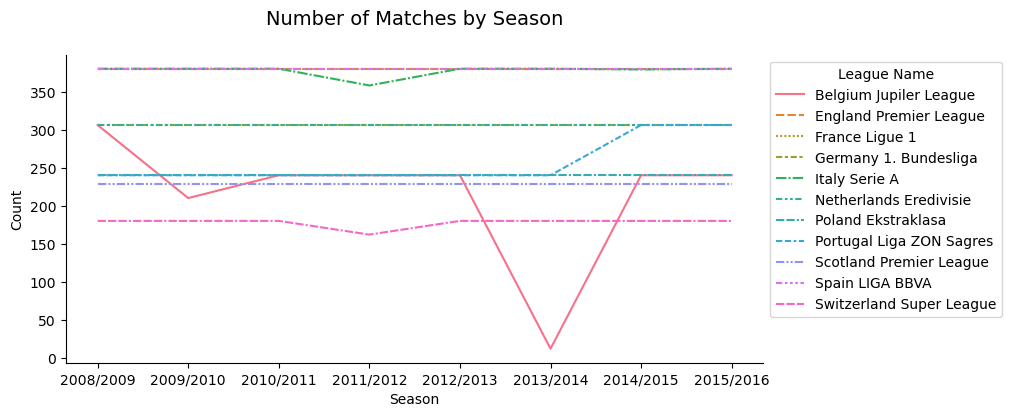

In [46]:
fig, ax1 = plt.subplots(figsize=(9, 4))
sns.lineplot(
    x="Season",
    y="Count",
    hue="League Name",
    style="League Name",
    data=matches_by_league_and_season,
    ax=ax1,
)
plt.legend(title="League Name", bbox_to_anchor=(1, 1))
ax1.set_title("Number of Matches by Season\n", color="black", fontsize=14)
sns.despine()

As observed, most of the leagues present very steady input of data throughout the years. There is a lack/small amount of data for the Belgium League in the season 2013/14

Let's take a look how these values for Belgium compare to the data from wikipedia.

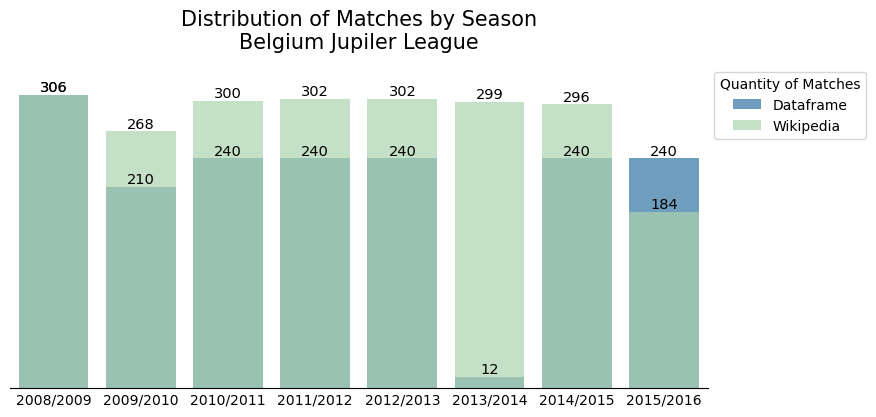

In [47]:
matches_belgium = matches_by_league_and_season[
    matches_by_league_and_season["league_id"] == 1
]

# Number of matches on wikipedia
Nr_matches_belgium = {
    "2008/2009": 306,
    "2009/2010": 268,
    "2010/2011": 300,
    "2011/2012": 302,
    "2012/2013": 302,
    "2013/2014": 299,
    "2014/2015": 296,
    "2015/2016": 184,
    "2016/2017": 191,
}

# Merge of real number of matches and dataframe count
matches_belgium["real_Nr_matches"] = matches_belgium["Season"].map(Nr_matches_belgium)


# Plot the data
fig, ax1 = plt.subplots(figsize=(9, 4))
sns.barplot(
    y="Count",
    x="Season",
    data=matches_belgium,
    color="tab:blue",
    alpha=0.7,
    label="Dataframe",
    ax=ax1,
)
sns.barplot(
    y="real_Nr_matches",
    x="Season",
    data=matches_belgium,
    color="#a6d9aa",
    alpha=0.7,
    label="Wikipedia",
    ax=ax1,
)
clear_barplot(
    ax1,
    plot_title="Distribution of Matches by Season\nBelgium Jupiler League\n",
    pad_top=0,
)
plt.legend(title="Quantity of Matches", bbox_to_anchor=(1, 1.05));

The comparison, between the quantity of matches reported on wikipedia and their counts in the dataframe, show that for most of the years not all of the matches were imported into the dataset. With an extrem case in 2013/2014. Besides, for the last year, the dataset has more values than the presented on wikipedia.

<h3 style="color:#4C8527">Goals Summary</h3>

The Match dataframe possesses a column called 'Goal' in which information of each goal of a match was stored.

For the extraction of these informations, a separated function called "extract_goal_summary" was created.

In [48]:
# Uses the "extract_goal_summary" function to extract the information of the goals in each match.
soccer_dict['Match']['goal_summary'] = soccer_dict['Match']['goal'].apply(lambda x: extract_goal_summary(x))
soccer_dict['Match']['goal_summary'][~soccer_dict['Match']['goal'].isnull()]

# Create a new feature with the number of goals for each match.
soccer_dict['Match']['Nr_goals_summary'] = soccer_dict['Match']['goal_summary'].apply(lambda x: len(x))

# Show 1 rows in the goal_summary
soccer_dict['Match']['goal_summary'][1729]

[{'goal_nr': 1,
  'event_incident_typefk': '393',
  'elapsed': '4',
  'player2': '39297',
  'subtype': 'shot',
  'player1': '26181',
  'sortorder': '2',
  'team': '9825',
  'id': '375546',
  'n': '231',
  'goal_type': 'n'}]

The function basically stores all the data in a list containing as many dictionaries as the number of goals in a match.
To check if the function does what it proposes some tests were carried out.

First, we compared if an empty list in "goals_summary" was being generated from any other output than "None" or "<goal '/>".

In [49]:
# Get all the matches without Null values / <goal />
filtered_matches = soccer_dict["Match"][
    ~((soccer_dict["Match"]["goal"].isnull())
    | soccer_dict["Match"]["goal"].str.contains("<goal />"))
]

# Check if 'goal_summary' has any empty lists, comming from valid 'goal' outputs
filtered_matches[
    filtered_matches["goal_summary"].str.len() == 0
]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,goal_summary,Nr_goals_summary


No empty list from valid 'goal' values.

Second, we evaluate the number of goals in "goal_summary" per league.

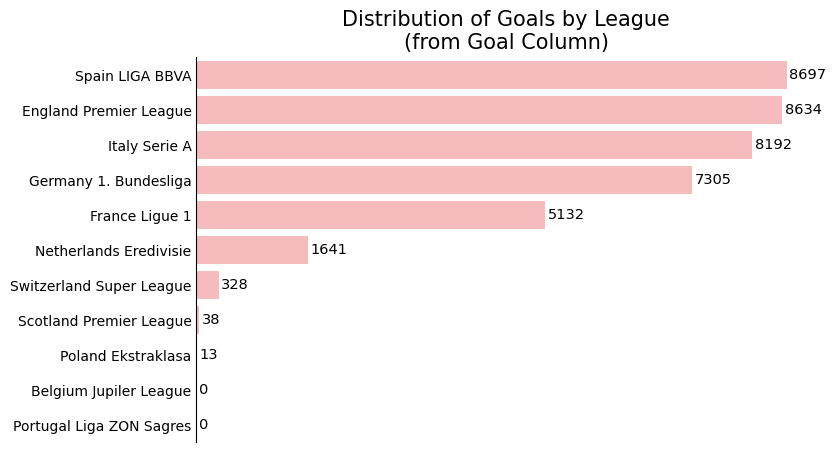

In [50]:
goals_summary = (
    soccer_dict["Match"]
    .groupby("league_id")
    .agg(
        Nr_matches=("id", "count"),
        Nr_goals_summary=("Nr_goals_summary", "sum"),
    )
    .reset_index()
    .sort_values(by="Nr_goals_summary", ascending=False)
)

goals_summary = pd.merge(
    goals_summary,
    soccer_dict["League"],
    left_on="league_id",
    right_on="id",
    how="inner",
).drop(["id", "country_id"], axis=1)


# Distribution of Goals from Summary
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.barplot(data=goals_summary, x='Nr_goals_summary', y='name', color="#ff9194", alpha=0.7, ax=ax1);
clear_barplot(ax1, plot_title="Distribution of Goals by League\n(from Goal Column)", pad_top=2, vertical=False)

As exposed, some leagues don't have match-wise information on their goals.

It is already an indication, that for the modeling phase, we will stick to one of these top 4 / top 5 leagues.

<h3 style="color:#4C8527">Goals by League </h3>

First, let's find the number of goals per match and explore the total number of goals per league. To make a more realistic analysis, let's also evaluate the average number of goals per match for each league. In between, the distribution of goals per match will also be plotted.

In [51]:
# Find the number of goals per match
soccer_dict["Match"]["Nr_goals"] = (
    soccer_dict["Match"]["home_team_goal"] + soccer_dict["Match"]["away_team_goal"]
)

# Percentage of matches with goals
matches_with_goals = soccer_dict['Match']['Nr_goals'][soccer_dict['Match']['Nr_goals'] != 0].shape[0]
total_matches = soccer_dict['Match'].shape[0]
percentage_with_goals = matches_with_goals * 100 / total_matches

print(f"The matches with goals amount to {percentage_with_goals:.1f}%")

The matches with goals amount to 92.4%


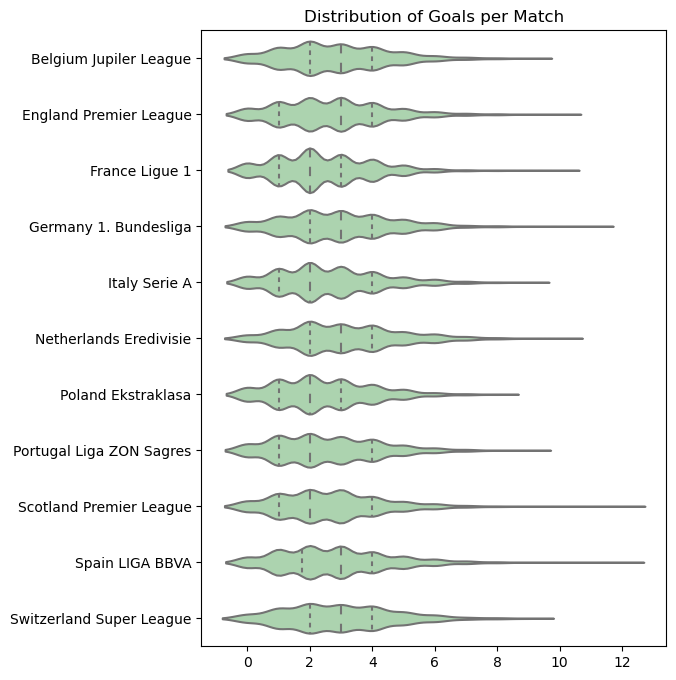

In [52]:
# Distribution of goals per match by league
goals_match = soccer_dict["Match"].loc[:, ["Nr_goals", "league_id"]]
goals_match = pd.merge(
    goals_match, soccer_dict["League"], left_on="league_id", right_on="id", how="inner"
).drop(["id", "country_id"], axis=1)
goals_match.columns = ["Nr_goals", "league_id", "League Name"]

fig, ax1 = plt.subplots(figsize=(6, 8))
sns.violinplot(
    data=goals_match, x="Nr_goals", y="League Name", inner="quartile", color="#a6d9aa", alpha=0.7, ax=ax1,
)
ax1.set(title="Distribution of Goals per Match", xlabel="", ylabel="");

Most of the league has as median values of 2 or 3 goals. Outliers are to be found in every league. The general tendency for most leagues is that 7 goals or more is an outlier. 

In [53]:
# Group the total number of goals and matches for each league
Nr_goals_league = soccer_dict['Match'].groupby('league_id').agg(
    Nr_matches=('id', 'count'),
    Nr_goals=('Nr_goals', 'sum'),
    home_team_goal=('home_team_goal', 'sum'),
    away_team_goal=('away_team_goal', 'sum'),
).reset_index().sort_values(by='Nr_goals', ascending=False)

# Merge League's name
Nr_goals_league = pd.merge(Nr_goals_league, soccer_dict['League'], left_on='league_id', right_on='id', how='inner').drop(['id', 'country_id'], axis=1)

# Find the number of goals per match
Nr_goals_league['goals_match'] = Nr_goals_league['Nr_goals'] / Nr_goals_league['Nr_matches']

# reoder columns
Nr_goals_league = Nr_goals_league[['league_id', 'name', 'Nr_matches', 'Nr_goals', 'goals_match', 'home_team_goal', 'away_team_goal']] 
Nr_goals_league

,league_id,name,Nr_matches,Nr_goals,goals_match,home_team_goal,away_team_goal
0,21518,Spain LIGA BBVA,3040,8412,2.767,4959,3453
1,1729,England Premier League,3040,8240,2.711,4715,3525
2,10257,Italy Serie A,3017,7895,2.617,4528,3367
3,13274,Netherlands Eredivisie,2448,7542,3.081,4357,3185
4,4769,France Ligue 1,3040,7427,2.443,4265,3162
5,7809,Germany 1. Bundesliga,2448,7103,2.902,3982,3121
6,17642,Portugal Liga ZON Sagres,2052,5201,2.535,2890,2311
7,1,Belgium Jupiler League,1728,4841,2.802,2781,2060
8,19694,Scotland Premier League,1824,4804,2.634,2607,2197
9,15722,Poland Ekstraklasa,1920,4656,2.425,2678,1978


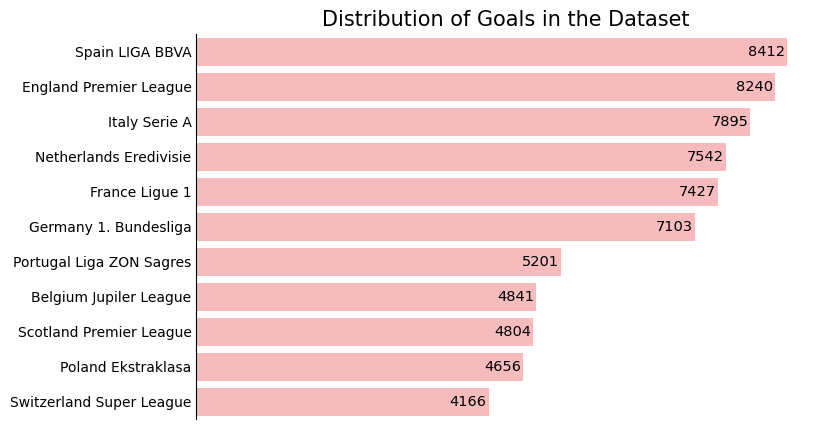

In [54]:
# Distribution of Goals by League
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.barplot(data=Nr_goals_league, x='Nr_goals', y='name', color="#ff9194", alpha=0.7, ax=ax1);
clear_barplot(ax1, plot_title="Distribution of Goals in the Dataset", pad_top=-28, vertical=False)

By league, in **absolut numbers Spain and England score the most** goals in the whole dataset; The ones scoring **the least are Poland and Switzerland**.

When **taking into consideration the total number of matches**, **Switzerland** becomes the second top scorer following **Netherlands**. **Poland stays in the bottom along with France**.

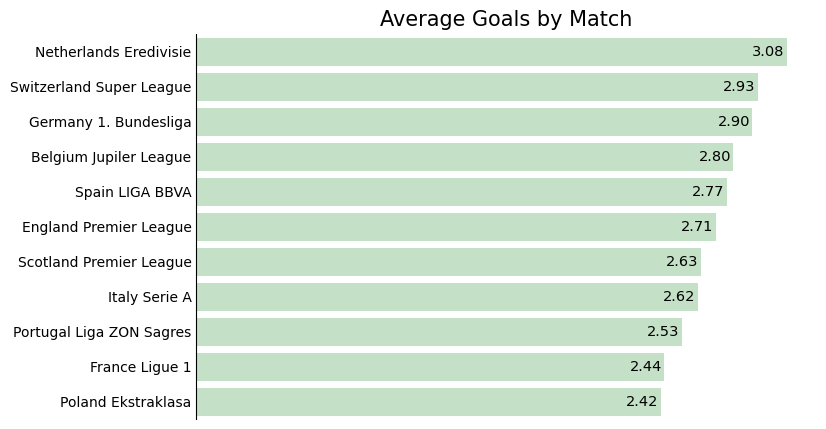

In [55]:
# Average goals per match
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=Nr_goals_league.sort_values(by="goals_match", ascending=False),
    x="goals_match",
    y="name",
    color="#a6d9aa",
    alpha=0.7,
    ax=ax1,
)
clear_barplot(ax1, plot_title="Average Goals by Match", pad_top=-25, vertical=False)

<h3 style="color:#4C8527">Home Advantage</h3>

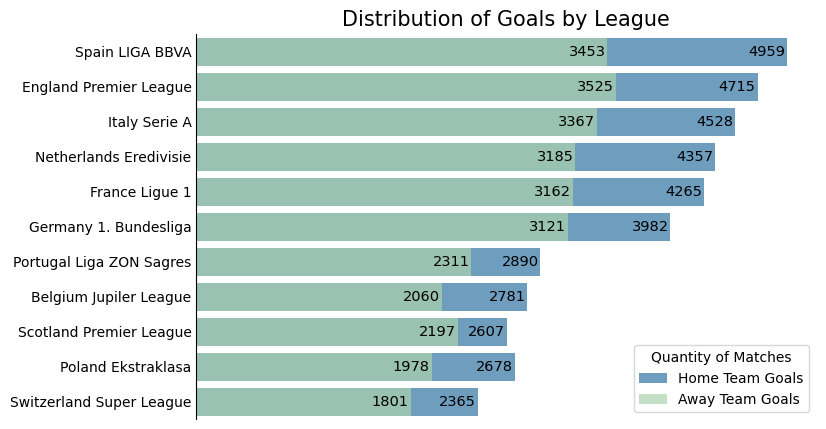

In [56]:
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.barplot(
    y="name",
    x="home_team_goal",
    data=Nr_goals_league,
    alpha=0.7,
    label="Home Team Goals",
    color="tab:blue",
    ax=ax1,
)
sns.barplot(
    y="name",
    x="away_team_goal",
    data=Nr_goals_league,
    alpha=0.7,
    label="Away Team Goals",
    color="#a6d9aa",
    ax=ax1,
)
clear_barplot(
    ax1, plot_title="Distribution of Goals by League", pad_top=-28, vertical=False
)
plt.legend(title="Quantity of Matches", loc="best");

The plot highlights that the **sum of goals** for all the matches **is greater for the home team**, which indicates already a **home advantage**, but needs to be supported with more research. 

Let's explore the winnings.

In [57]:
# Create a column to store who won the match
soccer_dict["Match"]["win"] = pd.np.where(
    soccer_dict["Match"]["home_team_goal"] > soccer_dict["Match"]["away_team_goal"],
    "Home Team Win",
    pd.np.where(
        soccer_dict["Match"]["home_team_goal"] < soccer_dict["Match"]["away_team_goal"],
        "Away Team Win",
        "Tie",
    ),
)

# create a df with the winning counts for home and away teams
win_counts = (
    soccer_dict["Match"]
    .groupby(["league_id", "win"])
    .size()
    .reset_index(name="count")
    .pivot(index="league_id", columns="win", values="count")
    .reset_index()
)

Nr_goals_league = pd.merge(Nr_goals_league, win_counts, on="league_id", how="inner")
Nr_goals_league

,league_id,name,Nr_matches,Nr_goals,goals_match,home_team_goal,away_team_goal,Away Team Win,Home Team Win,Tie
0,21518,Spain LIGA BBVA,3040,8412,2.767,4959,3453,851,1485,704
1,1729,England Premier League,3040,8240,2.711,4715,3525,867,1390,783
2,10257,Italy Serie A,3017,7895,2.617,4528,3367,814,1407,796
3,13274,Netherlands Eredivisie,2448,7542,3.081,4357,3185,696,1171,581
4,4769,France Ligue 1,3040,7427,2.443,4265,3162,822,1359,859
5,7809,Germany 1. Bundesliga,2448,7103,2.902,3982,3121,744,1107,597
6,17642,Portugal Liga ZON Sagres,2052,5201,2.535,2890,2311,611,908,533
7,1,Belgium Jupiler League,1728,4841,2.802,2781,2060,493,810,425
8,19694,Scotland Premier League,1824,4804,2.634,2607,2197,617,760,447
9,15722,Poland Ekstraklasa,1920,4656,2.425,2678,1978,525,870,525


In [58]:
# Calculate the percentages of winning (home and away) or tie.
Nr_goals_league["Home Win %"] = (Nr_goals_league["Home Team Win"] / Nr_goals_league["Nr_matches"]) * 100
Nr_goals_league["Away Win %"] = (Nr_goals_league["Away Team Win"] / Nr_goals_league["Nr_matches"]) * 100
Nr_goals_league["Tie %"] = (Nr_goals_league["Tie"] / Nr_goals_league["Nr_matches"]) * 100

In [59]:
# Long data for plot
Nr_goals_league_melt = Nr_goals_league.loc[:, ["name", "Away Team Win", "Home Team Win", "Tie"]].melt(
        id_vars="name", var_name="Result", value_name="Count")

# Long data for percentages
df_temp = Nr_goals_league.loc[:, ["name", "Away Win %", "Home Win %", "Tie %"]].melt(
    id_vars="name", var_name="Result", value_name="Percentage"
)

# Merge dataframes
dict_temp = {"Away Win %": "Away Team Win", "Home Win %": "Home Team Win", "Tie %": "Tie"}
df_temp['Result'] = df_temp['Result'].replace(dict_temp)

Nr_goals_league_melt = pd.merge(
    Nr_goals_league_melt,
    df_temp,
    left_on=["name", "Result"],
    right_on=["name", "Result"],
)

# create a list to plot the values on the bars
result_list = []

for result in Nr_goals_league_melt['Result'].unique():
    temp_list = Nr_goals_league_melt[Nr_goals_league_melt['Result'] == result]['Percentage'].tolist()
    temp_list = [f"{round(item, 2)}%" for item in temp_list]
    result_list.append(temp_list)

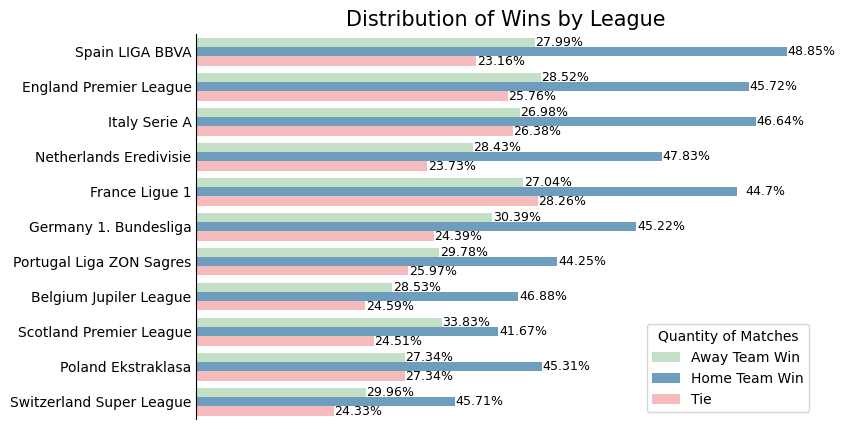

In [60]:
# Create the bar plot
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.barplot(
    y="name",
    x="Count",
    hue="Result",
    data=Nr_goals_league_melt,
    palette=["#a6d9aa", "tab:blue", "#ff9194"],
    alpha=0.7,
    ax=ax1,
)

# add percentage labels
for i, c in enumerate(ax1.containers):
    for j, rect in enumerate(c.patches):
        width = rect.get_width()
        ax1.annotate(result_list[i][j],
                     xy=(width, rect.get_y() + rect.get_height() / 2),
                     xytext=(35, 0),
                     textcoords="offset points",
                     ha='right', va='center', fontsize=9)

clear_barplot(
    ax1, plot_title="Distribution of Wins by League", pad_top=0, vertical=False, label_on_bars=False,
)
plt.legend(title="Quantity of Matches", loc="best");

**Visually speaking there is higher proportion of winnings for the Home Team**. The percentage of winning is normally around 45%, while for the away team this percentage 25% to 30%.

Can on say that these differences are statistically significant?


<h4 style="color:#4C8527">Formulating hypothesis</h4>
<p style="font-size: 1.1em; text-align: center; background:#dff1e1; color:black">"Are there significant differences in the number of winnings for the home teams and the away teams?" </p>


* Category 1:`'Home Teams'`
* Category 2:`'Away Teams'`

$$H_0: p_1 = p_2$$
$$H_0: p_1 = 0.5 of winnings$$
$$H_a: p_1 \ne 0.5$$

where $p_1$ and $p_2$ stand for the number of winnings for the Home and Away Teams, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.


We will perform a **one simple proportion test** to check our hypothesis.

In [61]:
# Drop the ties
non_tie_matches = soccer_dict['Match'].drop(soccer_dict['Match'][soccer_dict['Match']['win'] == 'Tie'].index, axis=0)
num_non_tie_matches = non_tie_matches.shape[0]

# Count the number of home team wins
num_home_team_wins = (soccer_dict['Match']['win'] == 'Home Team Win').sum()

# Define the hypothesized proportion (proportion of away team wins or ties)
expected_proportion = 0.5

# Perform the one-sample proportion test
z_stat, p_value = proportions_ztest(num_home_team_wins, num_non_tie_matches, expected_proportion)

# Print the results
print(f"Z-statistic:, {z_stat:.2f}")
print(f"P-value: {p_value:.2e}")

if p_value < 0.05:
    print("The number of home team wins is significantly higher than expected.")
else:
    print("There is no significant difference in the number of home team wins.")


Z-statistic:, 32.85
P-value: 1.21e-236
The number of home team wins is significantly higher than expected.


<h3 style="color:#4C8527">Top Scorers by League </h3>

The table Match does not contain specific information about the goals for all the leagues. In this way, the top scorers will be precised only for some of the leagues.

A way around this problem would be considering the players attributes table. This however would not provide effectively the number of goals of this top scorer and would be based only on measured parameters.

Here we present the top scorers for the season 2015/2016, but the same analysis could be carried out for any season with small code changes.

In [62]:
# Create a long dataframe to store all the goals
goals_long_df = []

# Iterate through each match's goal summary
for index, goals in enumerate(soccer_dict["Match"]["goal_summary"]):
    match_id = soccer_dict["Match"]["match_api_id"].iloc[index]
    season = soccer_dict["Match"]["season"].iloc[index]
    league_id = soccer_dict["Match"]["league_id"].iloc[index]

    # Iterate through each goal in the goal summary and extract the required information
    for goal in goals:
        player1 = goal["player1"]
        player2 = goal["player2"]

        goals_long_df.append(
            {
                "Match_id": match_id,
                "season": season,
                "league_id": league_id,
                "player1": player1,
            }
        )

goals_long_df = pd.DataFrame(goals_long_df)

In [63]:
# Merge League's name
goals_long_df = goals_long_df.merge(
    soccer_dict['League'][['id', 'name']],
    left_on='league_id',
    right_on='id',
    how='left'
).drop('id', axis=1)

# Drop rows with no player1
goals_long_df.drop(goals_long_df[goals_long_df['player1'].isna()].index, axis=0, inplace=True)

# Convert player_api_id in goals_long_df to int64
goals_long_df['player1'] = goals_long_df['player1'].astype(float).astype('int64')

# Merge for player1
goals_long_df = goals_long_df.merge(
    soccer_dict['Player'][['player_api_id', 'player_name']],
    left_on='player1',
    right_on='player_api_id',
    how='left'
)

goals_long_df.rename(columns={'player_name': 'player1_name', 'name':'league_name'}, inplace=True)
goals_long_df.drop('player_api_id', axis=1, inplace=True)
goals_long_df

,Match_id,season,league_id,player1,league_name,player1_name
0,489042,2008/2009,1729,37799,England Premier League,Obafemi Martins
1,489042,2008/2009,1729,24148,England Premier League,Darren Fletcher
2,489043,2008/2009,1729,26181,England Premier League,Samir Nasri
3,489044,2008/2009,1729,30853,England Premier League,Fernando Torres
4,489045,2008/2009,1729,23139,England Premier League,Dean Ashton
...,...,...,...,...,...,...
39858,1992228,2015/2016,24558,37554,Switzerland Super League,Guillaume Hoarau
39859,1992229,2015/2016,24558,493418,Switzerland Super League,Albion Avdijaj
39860,1992229,2015/2016,24558,197757,Switzerland Super League,Ivan Kecojevic
39861,1992229,2015/2016,24558,198082,Switzerland Super League,Oliver Buff


In [64]:
# Find the number of goals per season per player
goals_player = (
    goals_long_df.groupby(["player1", "player1_name", "league_name", "season"])
    .agg(goals_sum=("player1", "size"))
    .reset_index()
)
goals_player

,player1,player1_name,league_name,season,goals_sum
0,2752,Diego Mainz,Spain LIGA BBVA,2011/2012,1
1,2752,Diego Mainz,Spain LIGA BBVA,2012/2013,1
2,2752,Diego Mainz,Spain LIGA BBVA,2013/2014,1
3,2752,Diego Mainz,Spain LIGA BBVA,2014/2015,5
4,2768,Jose Dorado,Spain LIGA BBVA,2011/2012,3
...,...,...,...,...,...
10684,717270,Antoine Rabillard,France Ligue 1,2015/2016,1
10685,717557,Levi Garcia,Netherlands Eredivisie,2015/2016,1
10686,722766,Charly Musonda,Spain LIGA BBVA,2015/2016,1
10687,725718,Dennis van der Heijden,Netherlands Eredivisie,2015/2016,2


In [65]:
# Find the top scorers for the season 2015/2016
top_scorers_2015 = goals_player[goals_player["season"] == "2015/2016"].groupby("league_name").apply(
    lambda x: x.nlargest(5, "goals_sum")
).reset_index(drop=True)
top_scorers_2015.head(8)

,player1,player1_name,league_name,season,goals_sum
0,194165,Harry Kane,England Premier League,2015/2016,26
1,37412,Sergio Aguero,England Premier League,2015/2016,25
2,286119,Jamie Vardy,England Premier League,2015/2016,25
3,181276,Romelu Lukaku,England Premier League,2015/2016,20
4,278343,Riyad Mahrez,England Premier League,2015/2016,19
5,35724,Zlatan Ibrahimovic,France Ligue 1,2015/2016,41
6,169193,Alexandre Lacazette,France Ligue 1,2015/2016,22
7,49677,Edinson Cavani,France Ligue 1,2015/2016,20


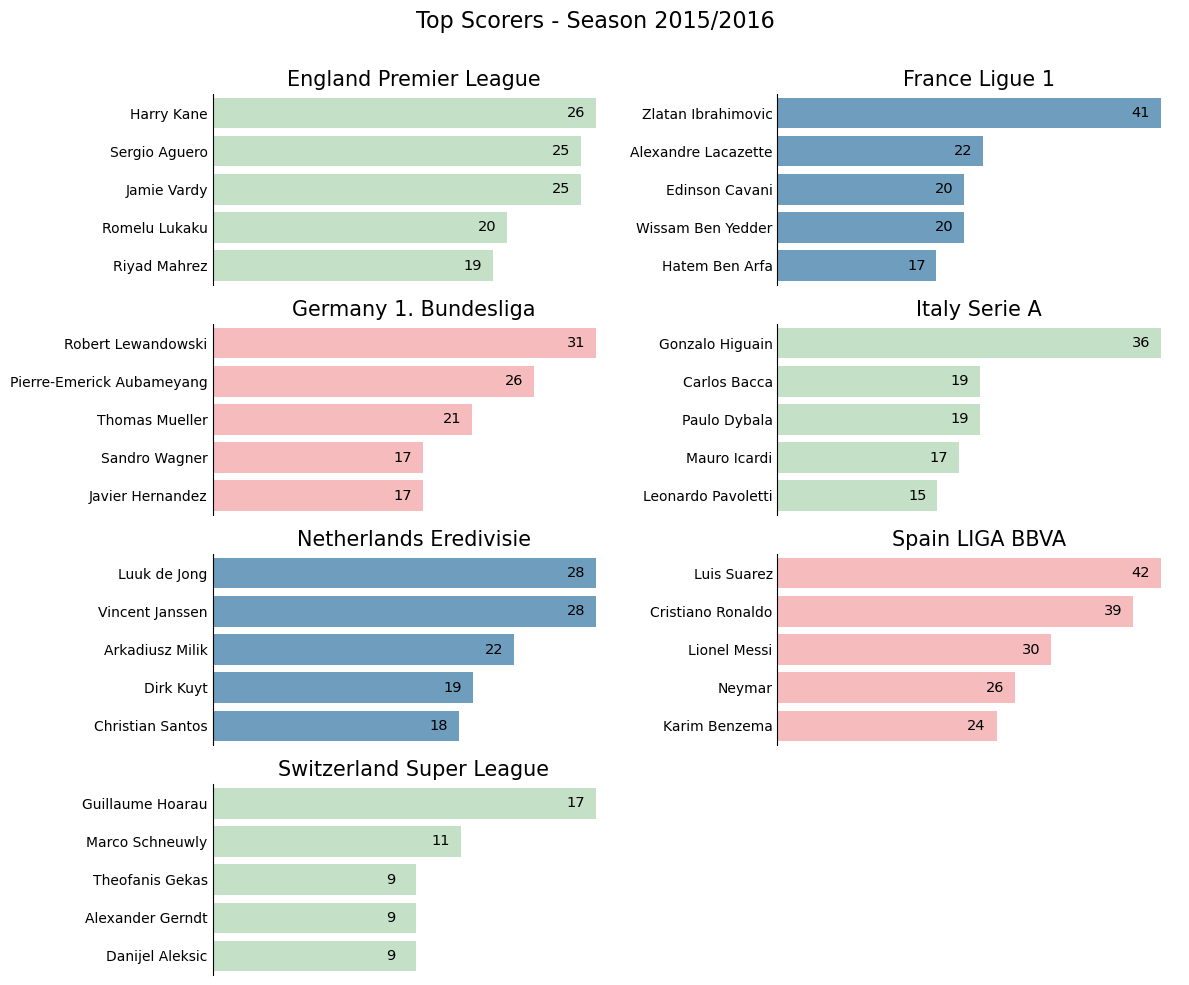

In [66]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))

# List of league names in the DataFrame
leagues = top_scorers_2015["league_name"].unique()
colors = ["#a6d9aa","tab:blue","#ff9194","#a6d9aa","tab:blue","#ff9194","#a6d9aa"]

# Loop through each subplot and plot the horizontal barplot for each league
for i, league in enumerate(leagues):
    ax = axes[i // 2, i % 2]
    sns.barplot(
        x="goals_sum",
        y="player1_name",
        data=top_scorers_2015[top_scorers_2015["league_name"] == league],
        color=colors[i],
        alpha=0.7,
        ax=ax,
    )
    clear_barplot(ax, plot_title=league, pad_top=-21, vertical=False)

plt.suptitle("Top Scorers - Season 2015/2016\n", fontsize=16)
fig.delaxes(axes.flatten()[7])   # Remove extra empty subplots
plt.tight_layout()               # Adjust spacing

This plot presents a good visualization for the top scorers in the season 2015/2016. Amongst the top scorers in all leagues, we see Suarez, Ibrahimovic and Cristiano Ronaldo.

<h3 style="color:#4C8527">Top Scorers by Team </h3>

Here again, we will limit our dataset to the season 2015/2016.
Due to the consistency of data in the column "goal" and to personal interest, we will also limit our output to the Spanish League.

In [67]:
# Set the mask for limiting our output and apply the mask to the new sliced dataframe
mask = (soccer_dict["Match"]["league_id"] == 21518) & (soccer_dict["Match"]["season"] == "2015/2016")
matches_spain_2015 = soccer_dict["Match"][mask]

matches_spain_2015.shape

(380, 119)

In [68]:
# Create a long dataframe to store all the goals
goals_team_spain_2015 = []

# Iterate through each match's goal summary
for index, goals in enumerate(matches_spain_2015["goal_summary"]):
    match_id = matches_spain_2015["match_api_id"].iloc[index]

    # Iterate through each goal in the goal summary and extract the required information
    for goal in goals:
        player1 = goal["player1"]
        team_id = goal["team"]

        # Skip if player1 is None
        if player1 is None:
            continue
            
        goals_team_spain_2015.append(
            {
                "Match_id": match_id,
                "player1": player1,
                "team_id": team_id,
            }
        )

goals_team_spain_2015 = pd.DataFrame(goals_team_spain_2015)

In [69]:
# Convert team_id and player_id
goals_team_spain_2015['team_id'] = goals_team_spain_2015['team_id'].astype('int64')
goals_team_spain_2015['player1'] = goals_team_spain_2015['player1'].astype(float).astype('int64')

# Merge Team's name
goals_team_spain_2015 = goals_team_spain_2015.merge(
    soccer_dict['Team'][['team_api_id', 'team_long_name']],
    left_on='team_id',
    right_on='team_api_id',
    how='left'
).drop('team_id', axis=1)

# Merge for player1
goals_team_spain_2015 = goals_team_spain_2015.merge(
    soccer_dict['Player'][['player_api_id', 'player_name']],
    left_on='player1',
    right_on='player_api_id',
    how='left'
)

goals_team_spain_2015.rename(columns={'player_name': 'Player', 'team_long_name':'Team'}, inplace=True)
goals_team_spain_2015.head()

,Match_id,player1,team_api_id,Team,player_api_id,Player
0,2030082,476769,8581,Levante UD,476769.000,Deyverson
1,2030082,49836,9910,RC Celta de Vigo,49836.000,Fabian Orellana
2,2030082,38469,8581,Levante UD,38469.000,Verza
3,2030082,174472,9910,RC Celta de Vigo,174472.000,Iago Aspas
4,2030083,184138,9906,Atlético Madrid,184138.000,Antoine Griezmann


In [70]:
# Find the number of goals per team per player
goals_player_spain_2015 = (
    goals_team_spain_2015.groupby(["player1", "Player", "Team"])
    .agg(goals_sum=("player1", "size"))
    .reset_index()
)
goals_player_spain_2015.head()

,player1,Player,Team,goals_sum
0,2802,Pablo Hernandez,Rayo Vallecano,3
1,2983,Jorge Molina,Real Betis Balompié,1
2,11736,Antolin Alcaraz,UD Las Palmas,1
3,17299,Carlos Carmona,Real Sporting de Gijón,2
4,19533,Neymar,FC Barcelona,26


In [71]:
# Find the 3 players with the most goals
top_3_players_teams = (
    goals_player_spain_2015.groupby(['Team', 'player1', 'Player'])
    .agg(total_goals=('goals_sum', 'sum'))
    .reset_index()
    .groupby(['Team'])
    .apply(lambda x: x.nlargest(3, 'total_goals'))
    .reset_index(drop=True)
)

# Find the top teams in number of goals
top_teams = goals_player_spain_2015.groupby('Team')['goals_sum'].sum().nlargest(5).index.tolist()

# Filter only for the top teams
top_3_players_teams = top_3_players_teams[top_3_players_teams['Team'].isin(top_teams)]
top_3_players_teams.head(3)

,Team,player1,Player,total_goals
0,Athletic Club de Bilbao,33028,Aritz Aduriz,23
1,Athletic Club de Bilbao,604105,Inaki Williams,8
2,Athletic Club de Bilbao,33871,Raul Garcia,7


In [72]:
top_3_players_teams.dtypes

Team           object
player1         int64
Player         object
total_goals     int64
dtype: object

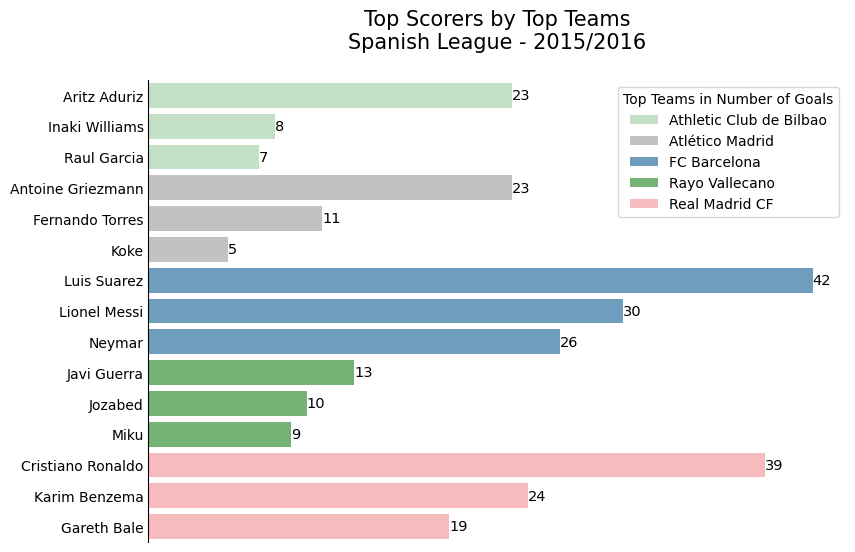

In [73]:
colors = ["#a6d9aa","darkgrey","tab:blue","tab:green","#ff9194"]

fig, ax1 = plt.subplots(figsize=(9, 6))
sns.barplot(
    x="total_goals",
    y="Player",
    hue="Team",
    data=top_3_players_teams,
    palette=colors,
    alpha=0.7,
    dodge=False,
    ax=ax1,
)
clear_barplot(ax1, plot_title="Top Scorers by Top Teams\nSpanish League - 2015/2016\n", pad_top=0, vertical=False)

plt.legend(title="Top Teams in Number of Goals", loc="best");

<h1 style="color:#4C8527">Conclusions </h1>

As shown in the exploration section:
- 11 leagues are encompassed in this dataset.


- The median weight for players in the european league is 76 kg and height 182 cm. 
- Repeated attributes were measured for each player in one season.
- A player's potential tends to be higher than their rating.


- The number of matches collected in each league is not constant for all of them.
- Specifically for the Belgian League, we could identify a gap in 2013/2014 and that the number of matches do not agree with what is stated on Wikipedia.


- The specification of goals is also not available for all the leagues.
- The median number of goals in the european matches is 2 or 3.
- Netherlands Erdivisie scores the most goals per match and Poland the least.
- The was a statistically signicant home advantage 45% against 25% (Away win) and 30% (draw).


- The top scorers in all leagues for the season 2015/2016 were Suarez, Ibrahimovic and Cristiano Ronaldo.
- By teams in the Spanish league, the top scorer for Real Madrid was Cristiano Ronaldo, and for FC Barcelona, Suarez.